### Reproducing the results of Wheler and Kiladis 99

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from pywk99.spectrum.spectrum import get_cross_spectrum
from pywk99.timeseries import remove_seasonal_cycle
from pywk99.timeseries import remove_linear_trend
from pywk99.waves import plot_dispersion_relations

In [2]:
import pywk99
pywk99.__version__

'0.4.4'

In [7]:
# run data/download.ipynb to download the example data
slp = xr.open_mfdataset("data/slp.19*.nc").slp.compute()
olr = xr.open_dataset("data/olr.2xdaily.1979-2022.nc").sel(
    time=slice("1979", "1996")
    ).resample({"time": "1D"}).mean().olr.compute()
variables = xr.Dataset({"olr": olr, "slp": slp})
variables = variables.sortby("lat")

In [10]:
variables_normalized = remove_linear_trend(variables)
variables_normalized = remove_seasonal_cycle(variables_normalized)

In [11]:
window_length = "92D"
overlap_length = "60D"
data_frequency = "1D"
taper_alpha = 0.1
symmetric_spectrum = get_cross_spectrum(
    variables_normalized,
    "symmetric",
    data_frequency,
    window_length,
    overlap_length,
    taper_alpha=taper_alpha,
)

In [13]:
COHERENCE_THRESHOLD = 0.05
coh2 = symmetric_spectrum.coherence_squared
coh2 = coh2.where(coh2 > COHERENCE_THRESHOLD, drop=True)
u = xr.apply_ufunc(np.real, symmetric_spectrum.cross) / np.abs(symmetric_spectrum.cross)
v = xr.apply_ufunc(np.imag, symmetric_spectrum.cross) / np.abs(symmetric_spectrum.cross)
u = u.where(coh2 > COHERENCE_THRESHOLD, drop=True)
v = v.where(coh2 > COHERENCE_THRESHOLD, drop=True)

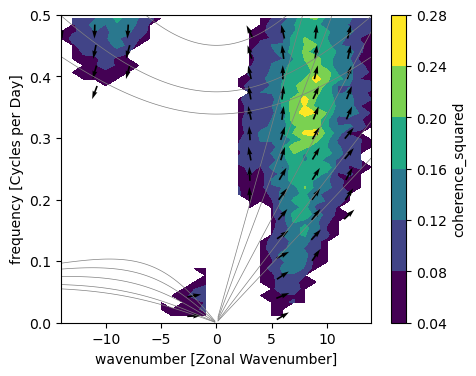

In [14]:
fig, ax = plt.subplots(1 , 1, figsize=(5, 4))
coh2.plot.contourf(ax=ax)
stride = 3
ax.quiver(u.wavenumber[::stride],
          u.frequency[::stride],
          u[::stride,::stride],
          v[::stride,::stride],
          angles="uv", pivot='mid', units='x', width=0.15)
plot_dispersion_relations("symmetric", ax, w_max=0.5)